# Туториал по нейросетевому подходу к численному интегрированию функции одной переменной

__Задача__: использовать нейросеть архитектуры MLP для численного интегрирования функции одной переменной.

__Использованные источники__: 

* Lloyd S., Irani R. A., Ahmadi M. Using neural networks for fast numerical integration and optimization //
IEEE Access. — 2020. — Т. 8. — С. 84519—84531.
* [Документация по Keras](https://www.tensorflow.org/guide/keras)
* [Документация по NumPy](https://numpy.org/doc/)
* [Документация по Mpmath](https://mpmath.org/doc/current/index.html)

## Немного теории

Численным интегралом функции одной переменной называют выражение вида:

$ I(f) = \int_{a}^{b} dx \{f(x)\} $ (1) 

В некоторых случаях неопределенный интеграл функции $f(x)$ может быть получен аналитически,
и тогда определенный интеграл можно выразить как 

$\int_{a}^{b} dx \{f(x)\} = F(b) - F(a)$, (2)

где $F(x) = \int dx \{f(x)\}$,
но иногда аналитическую форму сложно или невозможно получить и тогда прибегают к помощи численных 
методов.

Применить нейросетевой подход возможно образом, описаным далее.

__1. Нейросеть можно представить аналитически__

Нейросеть, так как она является лишь набором математических операций над числами в определенной 
последовательности, можно представить как некоторую функцию $\hat{f}(X)$, которая может быть 
задана аналитически:

$ \hat{f}(X) = b^{(2)} + W^{(2)T}\phi(b^{(1)}+W^{(1)}X) $ (3)

-- такое аналитическое представление имеет многослойный перцептрон (MLP) с одним скрытым слоем и 
функцией активации только на скрытом слое, где

$ W^{(1)}, W^{(2)} $ - векторы весов нейросети,

$ b^{(1)}, b^{(2)} $ - векторы смещений нейросети.

$ X $ - множество входных параметров (для функции одной переменной $|X| = 1$ и в дальнейшем будет 
указываться как $x$),

$ \phi(•) $ - функция активации скрытого слоя.

__2. Возможность аналитического интегрирования нейросети__

Приведенное выше аналитическое представление нейросети в зависимости от вида функции активации 
$ \phi $ возможно интегрировать аналитически. Это даёт возможность получить определенный интеграл 
нейросети $ \hat{f}(x) $ по формуле (2).

Представим нейросеть с помощью сумм:

$ \hat{f}(x) = b^{(2)} + \sum_{j=1}^{k}w_j^{(2)}\phi(b_j^{(1)}+w_{1j}^{(1)}x) $ (4),

где $ k $ - число нейронов скрытого слоя.

В данной архитектуре воспользуемся функцией активации *логистическая сигмоида*:

$ \phi(•) = \frac{1}{1 + e^{-(•)}} $ (5)
 
Для того, чтобы облегчить интегрирование нейросети воспользуемся выражением 
полилогарифма 0-го порядка и получим интеграл нейросети $\hat{f}(x)$, обозначив полученный интеграл 
$ \hat{I}(f) $:

$ \hat{I}(f) = \int_{\alpha}^{\beta} dx [b^{(2)} + \sum_{j=1}^{k}w_j^{(2)}\phi(b_j^{(1)}+w_{1j}^{(1)}x)] = $

$ = b^{(2)}(\beta - \alpha) + \sum_{j=1}^{k}w_{j}^{(2)}[(\beta - \alpha) + \frac{\Phi_{j}}{w_{1j}^{(1)}} ] $ (6.1)

$ \Phi_j = Li_1(-exp[-b_j^{(1)} - w_{1j}^{(1)}\alpha]) - Li_1(-exp[-b_j^{(1)} - w_{1j}^{(1)}\beta]) $ (6.2)

Как видно выше, формулы (6.1) и (6.2) позволяют, зная веса и смещения нейросети получить значение определенного 
интеграла нейросети $ \hat{f}(x) $.

Как же это может помочь нам в численном интегрировании нашей изначальной функции?

__3. Нейросетевое численное интегрирование__

Давайте попробуем аппроксимировать функцию $ f(x) $ нейросетью $ \hat{f}(x) $. Зная вид функции $ f(x) $ и 
её область определения $ A $ мы имеем возможность создать обучающее и тестовое множество 
$ TRAIN = \{ (x, y) | x \in A, y = f(x) \},$ $TEST = \{ (x, y) | x \in A, y = f(x) \}$ и провести 
процедуру обучения нейросети $ \hat{f}(x) $.

После достижения удовлетворяющей нас точности мы можем предположить, что данная нейросеть $ \hat{f}(x) $ 
аппроксимирует $ f(x) $, то есть, проще говоря, для любого $ x \in A $ значение 
$ \hat{f}(x) $ достаточно близко значению $ f(x) $:

$ |\hat{f}(x) - f(x)| < \epsilon $,

где $ \epsilon $ - удовлетворяющая нас погрешность.

Но пора перейти к практике и испробовать данный подход!

## Импорт необходимых библиотек

* Tensorflow Keras - работа с нейросетью.
* NumPy - работа с массивами данных и операциями над ними.
* Matplotlib - визуализация данных.
* Mpmath - необходим для имплементации полилогарифма.

In [118]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import math

from mpmath import polylog

from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import utils

from sklearn.model_selection import train_test_split


### Функция $f(x)$ и функция-генератор датасета

Будем тренировать модель аппроксимировать простую функцию $ f(x) = cos(x) $.

Определим функцию $ f(x) $ и функцию-генератор датасета.

In [122]:
def f_cos(x):
    return np.cos(x)

In [123]:
def generate_data(func, size=100):
    x = np.linspace(0, 1, size) 
    # вектор размера size из случайно сгенерированных !!!!!!! КАК? аргументов функции 
    y = func(x) # вектор значений функции
    return x, y

## Определение первой модели

In [287]:
first_model = keras.Sequential([
    Input(shape=(1,)),
    Dense(10, activation='sigmoid'),
    Dense(1)
])

test_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

У скрытого слоя 20 параметров: (1 нейрон + 1 смещение) * число_нейронов_скрытого_слоя,
у выходного слоя 10 параметров: 10 нейронов + 1 смещение.

### Гиперпараметры модели

In [288]:
input_size = 1 # так как у f(x) один параметр
hidden_size = 200 # число скрытых нейронов - можно варьировать
learning_rate = 0.001 # скорость обучения - можно варьировать
num_epochs = 500 # число эпох обучения - можно варьировать
samples = 10000 # мощность обучающего и тестового множеств - можно варьировать

### Генерация датасета и разделение на обучающую и тестовую выборки

In [289]:
X, Y = generate_data(f_cos, 10000)

In [290]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [291]:
first_model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mse')

In [292]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')]

In [293]:
history = first_model.fit(x_train, y_train, epochs=num_epochs, verbose=2, validation_split=0.2, callbacks=callbacks)

Epoch 1/500
200/200 - 0s - 2ms/step - loss: 0.2497 - val_loss: 0.0290
Epoch 2/500
200/200 - 0s - 500us/step - loss: 0.0237 - val_loss: 0.0208
Epoch 3/500
200/200 - 0s - 499us/step - loss: 0.0190 - val_loss: 0.0168
Epoch 4/500
200/200 - 0s - 490us/step - loss: 0.0149 - val_loss: 0.0128
Epoch 5/500
200/200 - 0s - 498us/step - loss: 0.0111 - val_loss: 0.0093
Epoch 6/500
200/200 - 0s - 490us/step - loss: 0.0078 - val_loss: 0.0064
Epoch 7/500
200/200 - 0s - 486us/step - loss: 0.0052 - val_loss: 0.0043
Epoch 8/500
200/200 - 0s - 498us/step - loss: 0.0034 - val_loss: 0.0028
Epoch 9/500
200/200 - 0s - 491us/step - loss: 0.0023 - val_loss: 0.0020
Epoch 10/500
200/200 - 0s - 522us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 11/500
200/200 - 0s - 491us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 12/500
200/200 - 0s - 492us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 13/500
200/200 - 0s - 481us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 14/500
200/200 - 0s - 506us/step - loss: 0.0012 - val_lo

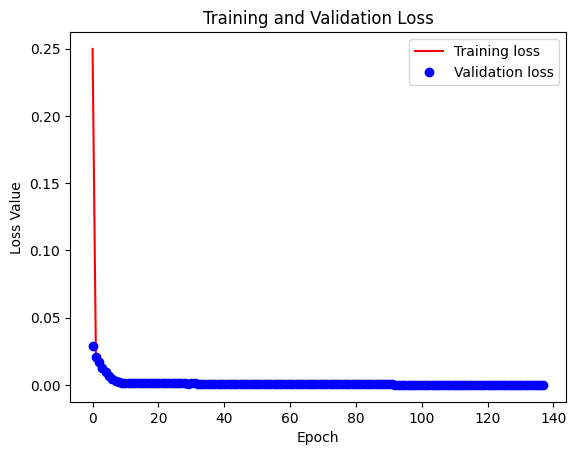

In [294]:
loss = first_model.history.history['loss']
val_loss = first_model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [295]:
test_loss = first_model.evaluate(x_test, y_test)
print(f"Test loss: {test_loss:.6f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 3.3225e-06
Test loss: 0.000003


In [296]:
def extract_model_params(model):
    b1 = model.layers[0].get_weights()[1]
    w1 = model.layers[0].get_weights()[0]
    b2 = model.layers[1].get_weights()[1]
    w2 = model.layers[1].get_weights()[0]

    b1 = np.reshape(b1, (-1,))
    w1 = np.reshape(w1, (-1,))
    b2 = np.reshape(b2, (-1,))
    w2 = np.reshape(w2, (-1,))

    return b1, w1, b2, w2

In [297]:
b1, w1, b2, w2 = extract_model_params(first_model)
b1.shape, w1.shape, b2.shape, w2.shape

((10,), (10,), (1,), (10,))

In [298]:
alpha = 0
beta = 1

In [299]:
def get_NN_analytical_integral(alpha, beta, b1, b2, weights_w1, weights_w2):

    def compute_phi_j(b1_j, w1_j, alpha, beta):
        term_alpha = polylog(1, -np.exp(-b1_j - w1_j * alpha))
        term_beta = polylog(1, -np.exp(-b1_j - w1_j * beta))
        return term_alpha - term_beta

    integral_sum = 0
    for w2, w1, b1_j in zip(weights_w2, weights_w1, b1):
        phi_j = compute_phi_j(b1_j, w1, alpha, beta)
        integral_sum += w2 * ((beta - alpha) + phi_j / w1)
    
    return b2 * (beta - alpha) + integral_sum

In [300]:
integral_cos = get_NN_analytical_integral(alpha, beta, b1, b2, w1, w2)
print(f"The analytical integral of cos(x) of the trained neural network model is: {float(integral_cos):.6f}")

The analytical integral of cos(x) of the trained neural network model is: 0.840212


/var/folders/df/v02b0vfx2tbc5plrdx4v6gk80000gn/T/ipykernel_60701/4274873537.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"The analytical integral of cos(x) of the trained neural network model is: {float(integral_cos):.6f}")


In [301]:
true_integral_cos = np.sin(beta) - np.sin(alpha)
print(f"The true ntegral of cos(x) is: {float(true_integral_cos):.6f}")

The true ntegral of cos(x) is: 0.841471
